***Vorlesung 'Syntax natürlicher Sprachen'***

--- 
# Intro Vorlesung 5: Syntaktische Funktionen (Dependenzanalyse)

In [1]:
import nltk

In [2]:
import spacy
from spacy import displacy
nlp = spacy.load('de_core_news_sm')

In [3]:
import os
from nltk.parse.stanford import StanfordDependencyParser

PATH_TO_CORE = os.path.join(os.getenv("HOME"), "nltk_data", "stanford-corenlp-full-2018-10-05")
PATH_TO_GERMAN_MODEL = os.path.join(os.getenv("HOME"), "nltk_data", "stanford-models-2018-10-05")

jar = os.path.join(PATH_TO_CORE, "stanford-corenlp-3.9.2.jar")
model = os.path.join(PATH_TO_GERMAN_MODEL, "stanford-german-corenlp-2018-10-05-models.jar")

stanford_dep_parser = StanfordDependencyParser(
    jar, model,
    model_path="edu/stanford/nlp/models/lexparser/" + 
    "englishPCFG.ser.gz"
)

In [4]:
from nltk import DependencyGraph
from nltk.tree import Tree
from itertools import chain


### tree_labeled-Methode für DependencyGraphs (pretty_print-Dependenzbäume mit Labels):
def _tree_labeled(self, i):
        node = self.get_by_address(i)
        word = node["word"]
        rel = node["rel"]        
        deps = sorted(chain.from_iterable(node["deps"].values()))

        if deps:
            return Tree(word+'('+rel+')', [self._tree_labeled(dep) for dep in deps])
        else:
            return word+'('+rel+')'
        
def tree_labeled(self):
        node = self.root

        word = node["word"]
        rel = node["rel"]
        deps = sorted(chain.from_iterable(node["deps"].values()))
        return Tree(word+'('+rel+')', [self._tree_labeled(dep) for dep in deps])

    
DependencyGraph._tree_labeled = _tree_labeled
DependencyGraph.tree_labeled = tree_labeled

In [5]:
#Konvertierungsfunktion von conll(4)-Format (MALT-tabular) für Rendering mit displaCy:
def displacy_dep_input(sent):
    deps = []
    for dep in sent.split('\n'):
        deps.append(dep.split())

    deps = [x for x in deps if x]

    ex = []
    word_list = []
    arc_list = []

    for index, dep in enumerate(deps):
        word_list.append({"text": dep[0], "tag": ""})
        line = index+1
        head = int(dep[2])
        label = dep[3]
        if head>line:
            start = index
            end = head-1
            direction = "left"
        else:
            start = head-1
            end = index  
            direction = "right"
        if(label.lower() != "root"):
            arc_list.append({"start": start, "end": end, "label": label, "dir": direction})

    ex.append({
        "words": word_list,
        "arcs": arc_list
    })    

    return ex

#html = displacy.render(ex, style="dep", manual=True, options={'distance':100})


### Dependenzrelationen
- **UD: https://universaldependencies.org/u/dep/ **
- **TIGER: https://www.linguistik.hu-berlin.de/de/institut/professuren/korpuslinguistik/mitarbeiter-innen/hagen/DDB_edge**
  - für Beispiele s. auch http://www.coli.uni-saarland.de/projects/sfb378/negra-corpus/kanten.html#MO

---

### Definition Dependenz
> Dependenz: strukturelle Beziehung zwischen zwei Konstituenten, die auf
Abhängigkeit beruht: Eine Konstituente B hängt von einer Konstituente A ab,
wenn A ohne B nicht stehen kann. (Dürscheid: Glossar)

---
 
## Syntaktische Funktionen (in einfachen Sätzen = *clauses*):

*(Syntaktische Funktionen komplexer Sätze: Sitzung 8)*

- *Syntaktische Funktion von ADJUNKTEN des Verbs:*
  - **Adverbial** (verbale Modifikatoren: Form und Auftreten unabhängig von Kopf): 
    - **nominale Adverbiale: `obl`/`nmod`** (**UD2/1**), `mo` (**TIGER**)
        - auch: ***Kasusadverbial:*** *läuft den ganzen Tag*, *kommt eines Tages*
    - **adverbielle Adverbiale: `advmod`**
    
    
- *Syntaktische Funktionen von Verb-KOMPLEMENTEN (valenzgefordert):*
  - (Verb selbst: **Prädikat** = `ROOT`)
  - **Subjekt: `nsubj`** (**UD**),  `sb`(**TIGER**)
  - **Objekt** (auch: ***Präpositionalobjekt***: *an etwas glauben*)
    - **direkt**: **`(d)obj`** (**UD**), `oa` (**TIGER**)
    - **indirekt**: **`iobj`** (**UD**),`da` (**TIGER**)
    - (Präpositionalobjekt: in UD als Adverbial `obl`/`nmod` (UD2/1), dagegen in TIGER als `op` = Objekt, präpositional)
  - (***adverbiale Komplemente*** als Adverbiale: `obl` (UD) `mo` (TIGER), z.B. *auf/neben den Tisch stellen*


- *Syntaktische Funktionen von ADJUNKTEN (und KOMPLEMENTEN) des Nomens:*
  - **Attribute** (nominale Modifikatoren: Form und Auftreten unabhängig von Kopf):
      - **nominale Modfikatoren: `nmod`** (**UD**), `nk` (**TIGER**)
          - weitere in UD: `amod`, `det` u.a.
          - weitere in TIGER: `ag` (Genitiv-Attribut)  u.a.


---
#### zu `obl`/`nmod`** (**UD2/1**), vgl. https://universaldependencies.org/u/dep/nmod.html:

> **`nmod: nominal modifier`**

> The `nmod` relation is used for nominal dependents of another noun or noun phrase and functionally corresponds to an attribute, or genitive complement.

> New from v2: The nmod relation was previously used also for nominal dependents of verbs, adjectives, and adverbs. The latter are now covered by the new `obl` relation.


## transitiver Beispielsatz: Dependenzgrammatik als Wortgrammatik

In [6]:
grammar = nltk.DependencyGrammar.fromstring("""
    'jagt' -> 'Hund' | 'Briefträger'
    'Hund' ->  'der' | 'den' | 'schreienden'
    'Briefträger' -> 'der' |'den' | 'schreienden'
    """)

parser = nltk.ProjectiveDependencyParser(grammar)

In [7]:
sent = 'der Hund jagt den schreienden Briefträger'.split()

for tree in parser.parse(sent):
    print(tree, "\n")
    tree.pretty_print(unicodelines=True)

(jagt (Hund der) (Briefträger den schreienden)) 

     jagt                        
 ┌────┴────────┐                  
Hund      Briefträger            
 │    ┌────────┴───────────┐      
der  den              schreienden



--- 

## Dependenzbäume zeichnen

- **https://www.nltk.org/_modules/nltk/parse/dependencygraph.html**
- http://stp.lingfil.uu.se/~nivre/research/MaltXML.html
- (CoNLL(10) or Malt-Tab(4) format)



- 0 = ROOT-Knoten
- Kennzeichung des Kopfs eines Dependenten über Zeilenangabe 

In [8]:
sent = """John N 2
loves V 0
Mary N 2
"""

dg = DependencyGraph(sent)
tree = dg.tree()
tree.pretty_print(unicodelines=True)  

     loves     
 ┌─────┴────┐   
John       Mary



In [9]:
print(tree)

(loves John Mary)


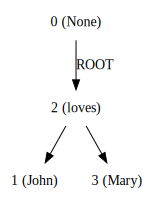

In [10]:
display(dg)

#### mit gelabelten Relationen (UD2):

In [11]:
sent = """der _ 2 det  
Hund _ 3 nsubj
jagt _ 0 ROOT
den _ 6 det
schreienden _ 6 amod 
Briefträger _ 3 obj
"""


dg = DependencyGraph(sent)
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)   

            jagt(ROOT)                                   
     ┌──────────┴─────────────┐                           
Hund(nsubj)            Briefträger(obj)                  
     │          ┌─────────────┴─────────────────┐         
  der(det)   den(det)                   schreienden(amod)



In [12]:
ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

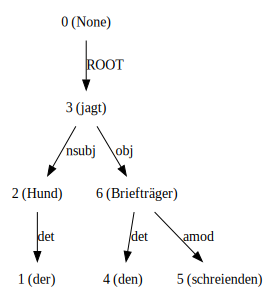

In [13]:
display(dg)

In [14]:
list(dg.triples())

[(('jagt', '_'), 'nsubj', ('Hund', '_')),
 (('Hund', '_'), 'det', ('der', '_')),
 (('jagt', '_'), 'obj', ('Briefträger', '_')),
 (('Briefträger', '_'), 'det', ('den', '_')),
 (('Briefträger', '_'), 'amod', ('schreienden', '_'))]

In [15]:
print(dg.to_conll(10))

1	der	der	_	_		2	det	_	_
2	Hund	Hund	_	_		3	nsubj	_	_
3	jagt	jagt	_	_		0	ROOT	_	_
4	den	den	_	_		6	det	_	_
5	schreienden	schreienden	_	_		6	amod	_	_
6	Briefträger	Briefträger	_	_		3	obj	_	_



--- 

## `spaCy`: Parsing mit  deutschem Modell, gelabelte Dependenzrelationen (`TIGER`)

- gelernt auf Korpus mit TIGER-Annotationsschema


- `mo`: verbale Adjunkte (Adverbiale)
- `sb` und `oa`: verbale Komplemente


- `nk`: nominale Adjunkte (Attribute)

In [16]:
sent = nlp('der Hund jagt den schreienden Briefträger')

for token in sent:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop, sep='\t')
displacy.render(sent, style='dep', options={'distance':100})        

der	der	DET	ART	nk	xxx	True	True
Hund	Hund	NOUN	NN	sb	Xxxx	True	False
jagt	jagen	VERB	VVFIN	ROOT	xxxx	True	False
den	der	DET	ART	nk	xxx	True	True
schreienden	schreiend	ADJ	ADJA	nk	xxxx	True	False
Briefträger	Briefträger	NOUN	NN	oa	Xxxxx	True	False


In [17]:
print(spacy.explain('sb'), spacy.explain('oa'), spacy.explain('nk'), sep="\n")

subject
accusative object
noun kernel element


--- 

## `Stanford-Parser`: Parsing mit englischem Modell, gelabelte Dependenzrelationen (`UD1`)

- gelernt auf Korpus mit PENN-TREEBANK-Annotationsschema + Transformationsregeln (von Konstituentenanalyse zu Dependenzanalyse in UD-Schema)


- `obl/nmod`: verbale Adjunkte (Adverbiale)
- `nsubj` und `(d)obj`: verbale Komplemente


- `nmod` (+`det`, `amod`): nominale Adjunkte (Attribute)

In [18]:
sent = 'the dog chases the screaming postman'
dg = list(stanford_dep_parser.raw_parse(sent))[0]
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)

ex = displacy_dep_input(dg.to_conll(4))
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

           chases(root)                              
    ┌───────────┴─────────────┐                       
dog(nsubj)              postman(dobj)                
    │           ┌─────────────┴──────────────┐        
 the(det)    the(det)                 screaming(amod)



In [19]:
#spacy.explain() funktioniert auch für UD-Label: 
print(spacy.explain('det'), spacy.explain('nsubj'), spacy.explain('obj'), spacy.explain('amod'), sep="\n")

determiner
nominal subject
object
adjectival modifier


---
### Beispiel Genitiv-Attribut

In [20]:
sent = nlp('der Hund jagt den Briefträger der Stadt')

for token in sent:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop, sep='\t')
displacy.render(sent, style='dep', options={'distance':100})        

der	der	DET	ART	nk	xxx	True	True
Hund	Hund	NOUN	NN	sb	Xxxx	True	False
jagt	jagen	VERB	VVFIN	ROOT	xxxx	True	False
den	der	DET	ART	nk	xxx	True	True
Briefträger	Briefträger	NOUN	NN	oa	Xxxxx	True	False
der	der	DET	ART	nk	xxx	True	True
Stadt	Stadt	NOUN	NN	ag	Xxxxx	True	False


In [21]:
print(spacy.explain('ag'), sep="\n")

genitive attribute


In [22]:
sent = 'the dog chases the town\'s postman'
dg = list(stanford_dep_parser.raw_parse(sent))[0]
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)

ex = displacy_dep_input(dg.to_conll(4))
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

           chases(root)                         
    ┌───────────┴──────────────┐                 
    │                    postman(dobj)          
    │                          │                 
dog(nsubj)              town(nmod:poss)         
    │           ┌──────────────┴───────────┐     
 the(det)    the(det)                   's(case)



In [23]:
print(spacy.explain('nmod'), spacy.explain('poss'), spacy.explain('case'), sep="\n")

modifier of nominal
possession modifier
case marking


---
### Beispiel indirektes Objekt

In [24]:
sent = nlp('der Briefträger übergibt der Stadt den Hund')

for token in sent:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop, sep='\t')
displacy.render(sent, style='dep', options={'distance':100})        

der	der	DET	ART	nk	xxx	True	True
Briefträger	Briefträger	NOUN	NN	sb	Xxxxx	True	False
übergibt	übergeben	VERB	VVFIN	ROOT	xxxx	True	False
der	der	DET	ART	nk	xxx	True	True
Stadt	Stadt	NOUN	NN	da	Xxxxx	True	False
den	der	DET	ART	nk	xxx	True	True
Hund	Hund	NOUN	NN	oa	Xxxx	True	False


In [25]:
print(spacy.explain('da'),spacy.explain('oa'), sep="\n")

dative
accusative object


In [26]:
sent = 'the postman gives the city the dog'
dg = list(stanford_dep_parser.raw_parse(sent))[0]
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)

ex = displacy_dep_input(dg.to_conll(4))
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

               gives(root)          
      ┌─────────────┼──────────┐     
postman(nsubj)  city(iobj) dog(dobj)
      │             │          │     
   the(det)      the(det)   the(det)



In [27]:
print(spacy.explain('dobj'), spacy.explain('iobj'), sep="\n")

direct object
indirect object


In [28]:
#UD2: obj statt dobj
print(spacy.explain('obj'), sep="\n")

object


---

## Abgrenzung und Analysen Adverbial - Objekt  (bzw. Komplement)

---
## Kasusadverbial (`obl` / `nmod`; `mo`)

- Objektkasus kann auch für die Markierung adverbialer Funktion fungieren: *Er läuft den ganzen Tag.* 
- weder Auftreten noch Form valenzgefordert (Adjunkt)

In [29]:
sent = nlp('Der Briefträger verschwand dieser Tage.')

for token in sent:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop, sep='\t')
displacy.render(sent, style='dep', options={'distance':100})        

Der	der	DET	ART	nk	Xxx	True	True
Briefträger	Briefträger	NOUN	NN	sb	Xxxxx	True	False
verschwand	verschwinden	VERB	VVFIN	ROOT	xxxx	True	False
dieser	dies	DET	PDAT	nk	xxxx	True	True
Tage	tagen	NOUN	NN	mo	Xxxx	True	True
.	.	PUNCT	$.	punct	.	False	False


In [30]:
print(spacy.explain('mo'), sep="\n")

modifier


In [31]:
sent = 'the postman disappeared these days'
dg = list(stanford_dep_parser.raw_parse(sent))[0]
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)

ex = displacy_dep_input(dg.to_conll(4))
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

               disappeared(root)                
      ┌────────────────┴────────────────┐        
postman(nsubj)                   days(nmod:tmod)
      │                                 │        
   the(det)                         these(det)  



In [32]:
print(spacy.explain('nmod'), sep="\n")
#UD 2: obl statt nmod für nominale Adverbiale ("nominaler Modifizierer von Verben oder Adjektiven"):
print(spacy.explain('obl'), sep="\n")

modifier of nominal
oblique nominal


---
## adverbiales präpositionales Komplement (`obl`/`nmod`;  `mo`)

- nur Auftreten valenzgefordert (Form nicht)
- wird wie nicht-valenzgeforderte Adverbiale analysiert


In [33]:
sent = nlp('ich stelle es auf den Tisch')

for token in sent:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop, sep='\t')
displacy.render(sent, style='dep', options={'distance':100})     

ich	ich	PRON	PPER	sb	xxx	True	True
stelle	stelle	VERB	VVFIN	ROOT	xxxx	True	False
es	ich	PRON	PPER	oa	xx	True	True
auf	auf	ADP	APPR	mo	xxx	True	True
den	der	DET	ART	nk	xxx	True	True
Tisch	tischen	NOUN	NN	nk	Xxxxx	True	False


In [34]:
print(spacy.explain('mo'), sep="\n")

modifier


In [35]:
sent = 'I put it on the table'
dg = list(stanford_dep_parser.raw_parse(sent))[0]
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)

ex = displacy_dep_input(dg.to_conll(4))
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

         put(root)                              
   ┌─────────┼───────────────────┐               
   │         │              table(nmod)         
   │         │        ┌──────────┴─────────┐     
I(nsubj)  it(dobj) on(case)             the(det)



In [36]:
print(spacy.explain('nmod'), sep="\n")
#UD 2: obl statt nmod für nominale Adverbiale ("nominaler Modifizierer von Verben oder Adjektiven"):
print(spacy.explain('obl'), sep="\n")

modifier of nominal
oblique nominal


---
#### vgl. im Beispiel auch die divergierende PP-Analyse: TIGER vs UD (`primacy of content words`):

    - TIGER: `auf -> Tisch (NK)`
    - UD: `table -> on (CASE)`

In [37]:
sent = """ich _ 2 sb
stelle _ 0 ROOT
es _ 2 oa
auf P 2 mo
den _ 6 nk
Tisch N 4 nk
"""

#TIGER (P = KOPF der PP)


dg = DependencyGraph(sent)
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)   

ex = displacy_dep_input(dg.to_conll(4))
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

        stelle(ROOT)          
   ┌─────────┼───────────┐     
   │         │        auf(mo) 
   │         │           │     
   │         │       Tisch(nk)
   │         │           │     
ich(sb)    es(oa)     den(nk) 



In [38]:
sent = """ich _ 2 nsubj
stelle _ 0 ROOT
es _ 2 obj
auf P 6 case
den _ 6 det
Tisch N 2 nmod/obl
"""
#UD (N = KOPF der PP > primacy of content words)

dg = DependencyGraph(sent)
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)   

ex = displacy_dep_input(dg.to_conll(4))
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

           stelle(ROOT)                                   
    ┌───────────┼────────────────────────┐                 
    │           │                 Tisch(nmod/obl)         
    │           │           ┌────────────┴───────────┐     
ich(nsubj)   es(obj)    auf(case)                 den(det)



In [39]:
#UD 2: obl statt nmod für nominale Adverbiale ("nominaler Modifizierer von Verben oder Adjektiven"):
print(spacy.explain('obl'), sep="\n")

oblique nominal


In [40]:
# UD 2: nmod eingeschränkt auf "nominaler Modifizierer eines Nomens"
#UD 1: nmod als "nominaler Modifizierer" (weiterer Begriff, umfasst auch obl, also nominalen Mod. von Verben oder Adj.)

print(spacy.explain('nmod'), sep="\n")

modifier of nominal


---
## Präpositionalobjekt: `obl/nmod` (UD2/1);  `op` (TIGER)

- Auftreten sowie Form (spezifische Präposition) valenzgefordert


- UD: Analyse wie Adverbial (`nmod` / `obl`) 
- d.h. Analyse als obliques Objekt (non-core argument)
- vgl. für das Deutsche: https://universaldependencies.org/de/dep/obl.html


- dagegen TIGER: als `op` (Präpositionalobjekt)

In [41]:
sent = nlp('ich glaube an dich')

for token in sent:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop, sep='\t')
displacy.render(sent, style='dep', options={'distance':100})

ich	ich	PRON	PPER	sb	xxx	True	True
glaube	glauben	VERB	VVFIN	ROOT	xxxx	True	False
an	an	ADP	APPR	op	xx	True	True
dich	sich	PRON	PPER	nk	xxxx	True	True


In [42]:
print(spacy.explain('op'), sep="\n")

prepositional object


In [43]:
sent = 'I believe in you'
dg = list(stanford_dep_parser.raw_parse(sent))[0]
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)

ex = displacy_dep_input(dg.to_conll(4))
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

         believe(root)          
   ┌───────────┴───────────┐     
   │                   you(nmod)
   │                       │     
I(nsubj)                in(case)



In [44]:
print(spacy.explain('nmod'), sep="\n")
#UD 2: obl statt nmod für nominale Adverbiale ("nominaler Modifizierer von Verben oder Adjektiven"):
print(spacy.explain('obl'), sep="\n")

modifier of nominal
oblique nominal


--- 
## Beispielsatz mit Präpositionalobjekt (`op`) und präpositionalem Adverbial (`mo`)

In [45]:
# präpositionales Adverbial (=Adjunkt und präpositionales Objekt (Komplement):
sent = nlp('ich warte im Park auf die Sonne')
for token in sent:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop, sep='\t')
displacy.render(sent, style='dep', options={'distance':100})


##im Lexikon (Subkat): waren + auf! (Auftreten+Form valenzgefordert)

ich	ich	PRON	PPER	sb	xxx	True	True
warte	warten	VERB	VVFIN	ROOT	xxxx	True	False
im	im	ADP	APPRART	mo	xx	True	True
Park	parken	NOUN	NN	nk	Xxxx	True	False
auf	auf	ADP	APPR	op	xxx	True	True
die	der	DET	ART	nk	xxx	True	True
Sonne	sonnen	NOUN	NN	nk	Xxxxx	True	False


In [46]:
print(spacy.explain('op'), spacy.explain('mo'), sep="\n")

prepositional object
modifier
